## Back-door example from DOWHY but using Ananke

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from ananke.graphs import ADMG
from ananke.estimation import CausalEffect
from ananke.datasets import load_afixable_data, load_conditionally_ignorable_data, load_frontdoor_data
from ananke.estimation import AutomatedIF

from CASTLE2 import CASTLE
from utils import heat_mat, plot_DAG, DAG_retreive_np, save_pickle, load_pickle, random_stability

Instructions for updating:
non-resource variables are not supported in the long term


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          9.778e+05
Date:                Thu, 30 Dec 2021   Prob (F-statistic):                        0.00
Time:                        11:25:24   Log-Likelihood:                          4322.4
No. Observations:                5000   AIC:                                     -8641.
Df Residuals:                    4998   BIC:                                     -8628.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

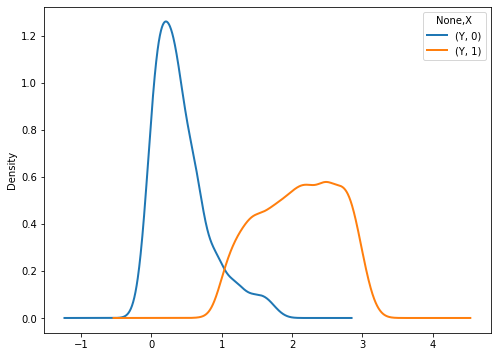

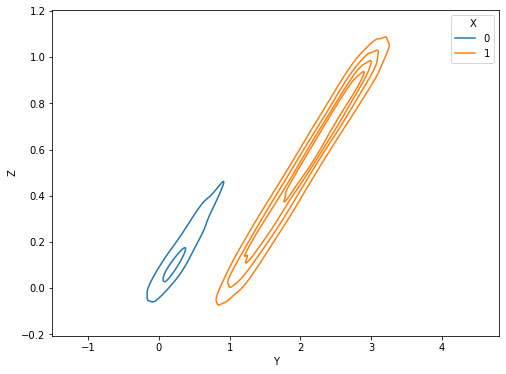

In [25]:
random_stability(123)
N = 5000

xy_coef = 1.
zy_coef = 2.

zx_coef = -5.
uy_coef = 0.1

# z_transform = lambda x : np.log(x)

z = np.random.uniform(size=N)
x = np.random.binomial(1., p=1./(1. + np.exp(zx_coef * z)))
u = np.random.normal(size=N, loc=0., scale=1.)

y = zy_coef * z + xy_coef * x + uy_coef * u
#z_transform(
    # ) 
    

data = pd.DataFrame({'Z': z, 'X': x, 'Y': y})

data.describe()

import statsmodels.api as sm
mod = sm.OLS(data[['Y']], data[['X','Z']])
fii = mod.fit()
print(fii.summary())

print('Total Effect:',data[data['X']==1.].mean(axis=0)['Y'],'-',data[data['X']==0.].mean(axis=0)['Y'], '=', (data[data['X']==1.].mean(axis=0) - data[data['X']==0.].mean(axis=0))['Y'])

data_wide = data.pivot(columns = 'X', values = ['Y'])
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 2)

plt.show()

# features = data[['X','Y','Z']].values.T
# plt.scatter(features[1], features[2], alpha=0.2,
#             # s=100*features[0], 
#             c=data.X, cmap='coolwarm'
#             )
# plt.xlabel(data[['X','Y','Z']].columns[1])
# plt.ylabel(data[['X','Y','Z']].columns[2]);
# plt.show()

fig, ax = plt.subplots(figsize= (8, 6))
ax.set(xlim=(-1.5, 4.8))
sns.kdeplot(ax=ax, data=data[['X','Y','Z']], x="Y", y="Z", hue="X",
            levels=5, thresh=.1, fill=False,
            )

plt.show()



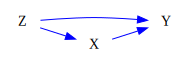

In [3]:
vertices = ['Z', 'Y', 'X']
di_edges = [('X', 'Y'), ('Z', 'Y'), ('Z', 'X')]
G = ADMG(vertices, di_edges)
G.draw(direction="LR")

In [4]:
ace_obj = CausalEffect(graph=G, treatment='X', outcome='Y')  # setting up the CausalEffect object


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



In [5]:
ace = ace_obj.compute_effect(data, "eff-aipw") # computing the effect 
print("ace = ", ace, "\n")

ace =  1.0116817648921175 



In [6]:
X_DAG = data[['X', 'Z']].to_numpy()
Y_DAG = data[['Y']].to_numpy()

print(X_DAG, Y_DAG)

[[1.         0.69646919]
 [1.         0.28613933]
 [0.         0.22685145]
 ...
 [0.         0.43162427]
 [1.         0.94270979]
 [0.         0.04399307]] [[ 2.48877846]
 [ 1.61829458]
 [ 0.40842469]
 ...
 [ 0.77574624]
 [ 2.83649424]
 [-0.13164774]]


In [15]:

n_folds = 1

if n_folds > 1:
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)

    fold = 0
    REG_castle = []
    print("Dataset limits are", np.ptp(X_DAG), np.ptp(X_test), np.ptp(y_test))
    for train_idx, val_idx in kf.split(X_DAG):
        fold += 1
        print("fold = ", fold)
        print("******* Doing dataset size = ", len(train_idx) , "****************")
        X_train = X_DAG[train_idx]
        y_train = np.expand_dims(X_DAG[train_idx][:,0], -1)
        X_val = X_DAG[val_idx]
        y_val = X_DAG[val_idx][:,0]

        w_threshold = 0.3
        castle = CASTLE(num_train = X_DAG.shape[0], num_inputs = X_DAG.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                            w_threshold = w_threshold, ckpt_file = ckpt_file
                        )

        num_nodes = np.shape(X_DAG)[1]
        castle.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_val, y_val=y_val,
                overwrite=True, tune=False, maxed_adj=None, tuned=False)

        W_est = castle.pred_W(X_DAG, np.expand_dims(X_DAG[:,0], -1))
        heat_mat(W_est)
        REG_castle.append(mean_squared_error(castle.pred(X_val), y_val))
        print("MSE = ", mean_squared_error(castle.pred(X_val), y_val))

        if fold > 1:
            print("MEAN =", np.mean(REG_castle), "STD =", np.std(REG_castle))
else:


    
    tune = False
    tuned = False
    force_refit = True
    reg_lambda = 1
    reg_beta = 5
    output_log = 'castle.log'
    ckpt_file = 'tmp.ckpt'
    seed = 2021
    loaded_adj = None ## Adjacency matrix to be injected

    print("******* Doing dataset size = ", X_DAG.shape[0] , "****************")
    scaler = StandardScaler()
    X_DAG_st = scaler.fit_transform(X_DAG)
    XY_DAG_st = np.c_[Y_DAG,X_DAG_st]

    X_train, X_test = train_test_split(XY_DAG_st,random_state=1, test_size=0.2)
    print(X_train.shape, X_test.shape)

    y_train = np.expand_dims(X_train[:,0], -1)
    y_test = np.expand_dims(X_test[:,0], -1)

    w_threshold = 0.3
    castle = CASTLE(num_train = X_train.shape[0], num_inputs = X_train.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                        w_threshold = w_threshold, ckpt_file = ckpt_file, seed = seed
                    )

    castle.fit(X=X_train, y=y_train, num_nodes=X_train.shape[1], X_val=X_test, y_val=y_test,
            overwrite=force_refit, tune=tune, tuned=tuned, maxed_adj=loaded_adj, seed = seed )
    print("MSE = ", mean_squared_error(castle.pred(X_test), y_test))

    W_est = castle.pred_W(XY_DAG_st, np.expand_dims(XY_DAG_st[:,0], -1))
    heat_mat(W_est)

******* Doing dataset size =  5000 ****************
(4000, 3) (1000, 3)
Step 1, Loss= 0.8568 h_value: 5.197525e-05
Val Loss= 0.0116
Step 2, Loss= 0.0111 h_value: 0.00011754036
Val Loss= 0.0110
Step 3, Loss= 0.0108 h_value: 7.390976e-05
Val Loss= 0.0115
Step 4, Loss= 0.0110 h_value: 3.2186508e-05
Val Loss= 0.0110
Step 5, Loss= 0.0106 h_value: 1.5497208e-05
Val Loss= 0.0126
Step 6, Loss= 0.0126 h_value: 9.775162e-06
Val Loss= 0.0119
Step 7, Loss= 0.0118 h_value: 6.198883e-06
Val Loss= 0.0125
Step 8, Loss= 0.0124 h_value: 5.00679e-06
Val Loss= 0.0112
Step 9, Loss= 0.0107 h_value: 4.7683716e-06
Val Loss= 0.0108
Step 10, Loss= 0.0106 h_value: 4.2915344e-06
Val Loss= 0.0121
Step 11, Loss= 0.0121 h_value: 4.529953e-06
Val Loss= 0.0121
Step 12, Loss= 0.0114 h_value: 3.8146973e-06
Val Loss= 0.0163
Step 13, Loss= 0.0164 h_value: 4.2915344e-06
Val Loss= 0.0114
Step 14, Loss= 0.0108 h_value: 3.33786e-06
Val Loss= 0.0122
Step 15, Loss= 0.0118 h_value: 3.33786e-06
Val Loss= 0.0112
Step 16, Loss= 0.0

INFO:tensorflow:Restoring parameters from tmp.ckpt


Val Loss= 0.0131
Early stopping
MSE =  0.010733363721873609


,0,1,2
0,0.0,0.063,0.049
1,0.007,0.0,0.018
2,0.011,0.034,0.0


In [8]:
# castle.pred(X_DAG[X_DAG[:,1]==1.]).mean() - castle.pred(X_DAG[X_DAG[:,1]==0.]).mean()
print('Total Effect:',data[data.X == 1].mean()['Y'] ,'-',data[data.X == 0].mean()['Y'], '='  ,(data[data.X == 1].mean() - data[data.X == 0].mean())['Y'])

ace = castle.pred(XY_DAG_st[X_DAG[:,0]==1.]).mean() - castle.pred(XY_DAG_st[X_DAG[:,0]==0.]).mean()
print('ACE:', castle.pred(XY_DAG_st[X_DAG[:,0]==1.]).mean(), '-' ,castle.pred(XY_DAG_st[X_DAG[:,0]==0.]).mean(), '=' ,ace)

# XY_DAG_st[X_DAG[:,0]==1.].shape[0] + XY_DAG_st[X_DAG[:,0]==0.].shape[0] == XY_DAG_st.shape[0]
# XY_DAG_st[X_DAG[:,0]==0.].shape[0]
# XY_DAG_st[X_DAG[:,0]==0.].shape[0]

Total Effect: 2.0930266429221063 - 0.42603715841020756 = 1.6669894845118987
ACE: 2.1024501 - 0.41762844 = 1.6848217


<AxesSubplot:ylabel='Density'>

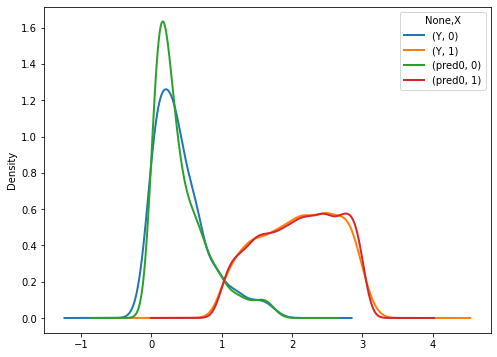

In [9]:
data['pred0'] = castle.pred(XY_DAG_st)
data_wide = data.pivot(columns = 'X', values = ['Y','pred0'])
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 2)

<AxesSubplot:xlabel='pred0', ylabel='Y'>

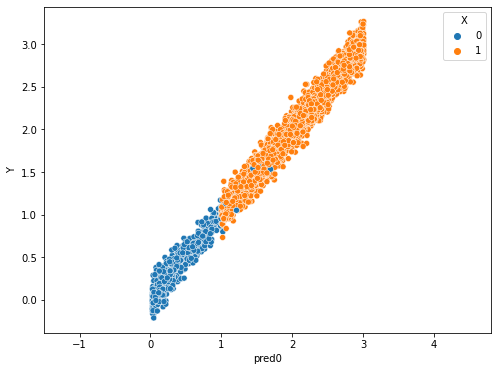

In [10]:
fig, ax = plt.subplots(figsize= (8, 6))
ax.set(xlim=(-1.5, 4.8))
sns.scatterplot(ax=ax, data=data[['X','Y','pred0','Z']], x='pred0', y="Y", hue="X",
            #levels=10, thresh=.1, fill=False,
            )

In [11]:
true_adj = np.array([[0,0,0],[1,0,0],[1,1,0]])

true_adj

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0]])

In [16]:
tune = True
tuned = False
force_refit = True

print("******* Doing dataset size = ", X_DAG.shape[0] , "****************")
# scaler = StandardScaler()
# X_DAG_st = scaler.fit_transform(X_DAG)

# X_train, X_test = train_test_split(X_DAG_st,random_state=1, test_size=0.2)
# print(X_train.shape, X_test.shape)

# y_train = np.expand_dims(X_train[:,0], -1)
# y_test = np.expand_dims(X_test[:,0], -1)

w_threshold = 0.3
castle2 = CASTLE(num_train = X_train.shape[0], num_inputs = X_train.shape[1], reg_lambda = reg_lambda, reg_beta = reg_beta,
                    w_threshold = w_threshold, ckpt_file = ckpt_file, seed = seed, adj_mat= true_adj, tune=tune
                )

num_nodes = np.shape(X_train)[1]
castle2.fit(X=X_train, y=y_train, num_nodes=num_nodes, X_val=X_test, y_val=y_test,
        overwrite=force_refit, tune=tune, tuned=tuned, maxed_adj=true_adj, seed = seed )
print("MSE = ", mean_squared_error(castle2.pred(X_test), y_test))

W_est = castle2.pred_W(XY_DAG_st, np.expand_dims(XY_DAG_st[:,0], -1))
heat_mat(W_est)

******* Doing dataset size =  5000 ****************


Exception ignored in: <bound method CASTLE.__del__ of <CASTLE2.CASTLE object at 0x7f7b7c430160>>
Traceback (most recent call last):
  File "/vol/bitbucket/fr920/CASTLE/CASTLE2.py", line 295, in __del__
    tf.reset_default_graph()
  File "/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 6042, in reset_default_graph
    raise AssertionError("Do not use tf.reset_default_graph() to clear "
AssertionError: Do not use tf.reset_default_graph() to clear nested graphs. If you need a cleared graph, exit the nesting and create a new graph.
Exception ignored in: <bound method CASTLE.__del__ of <CASTLE2.CASTLE object at 0x7f7b587baba8>>
Traceback (most recent call last):
  File "/vol/bitbucket/fr920/CASTLE/CASTLE2.py", line 295, in __del__
    tf.reset_default_graph()
  File "/vol/bitbucket/fr920/envs/bayesenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 6042, in reset_default_graph
    raise AssertionError("Do not us

Model Loaded from  tmp.ckpt
Begin Tuning - Apply Mask from DAG
Step 1, Loss= 18.0683 h_value: 0.0
Val Loss= 0.0228
Step 2, Loss= 0.0214 h_value: 0.0
Val Loss= 0.0133
Step 3, Loss= 0.0124 h_value: 0.0
Val Loss= 0.0121
Step 4, Loss= 0.0114 h_value: 0.0
Val Loss= 0.0120
Step 5, Loss= 0.0111 h_value: 0.0
Val Loss= 0.0114
Step 6, Loss= 0.0109 h_value: 0.0
Val Loss= 0.0111
Step 7, Loss= 0.0107 h_value: 0.0
Val Loss= 0.0111
Step 8, Loss= 0.0106 h_value: 0.0
Val Loss= 0.0110
Step 9, Loss= 0.0105 h_value: 0.0
Val Loss= 0.0114
Step 10, Loss= 0.0109 h_value: 0.0
Val Loss= 0.0111
Step 11, Loss= 0.0106 h_value: 0.0
Val Loss= 0.0113
Step 12, Loss= 0.0107 h_value: 0.0
Val Loss= 0.0112
Step 13, Loss= 0.0106 h_value: 0.0
Val Loss= 0.0118
Step 14, Loss= 0.0112 h_value: 0.0
Val Loss= 0.0111
Step 15, Loss= 0.0108 h_value: 0.0
Val Loss= 0.0115
Step 16, Loss= 0.0110 h_value: 0.0
Val Loss= 0.0117
Step 17, Loss= 0.0113 h_value: 0.0
Val Loss= 0.0110
Step 18, Loss= 0.0105 h_value: 0.0
Val Loss= 0.0121
Step 19, 

INFO:tensorflow:Restoring parameters from tmp.ckpt_tuned


Val Loss= 0.0128
Early stopping
MSE =  0.010757886247102917


,0,1,2
0,0.0,0.0,0.0
1,0.015,0.0,0.0
2,0.025,0.06,0.0


In [17]:
print('ACE:', castle2.pred(XY_DAG_st[X_DAG[:,0]==1.]).mean(), '-' ,castle2.pred(XY_DAG_st[X_DAG[:,0]==0.]).mean(), '=' ,castle2.pred(XY_DAG_st[X_DAG[:,0]==1.]).mean() - castle2.pred(XY_DAG_st[X_DAG[:,0]==0.]).mean())
# print('ACE:', castle2.pred(X_DAG_st[X_DAG_st[:,1]>0.]).mean(), '-' ,castle2.pred(X_DAG_st[X_DAG_st[:,1]<0.]).mean(), '=' ,castle2.pred(X_DAG_st[X_DAG_st[:,1]>0.]).mean() - castle2.pred(X_DAG_st[X_DAG_st[:,1]<0.]).mean())

ACE: 2.1080973 - 0.4301381 = 1.6779592


<AxesSubplot:ylabel='Density'>

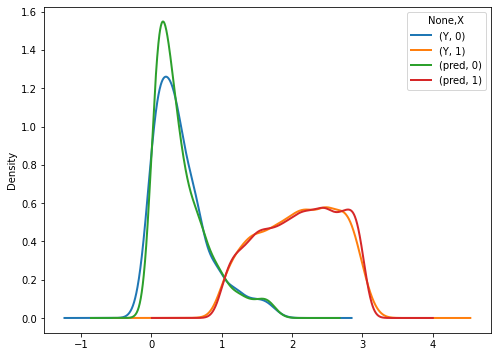

In [18]:
data['pred'] = castle2.pred(XY_DAG_st)
data_wide = data.pivot(columns = 'X', values = ['Y','pred'])
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 2)

<AxesSubplot:xlabel='pred', ylabel='pred0'>

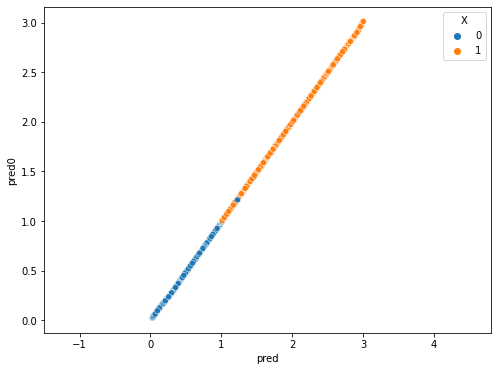

In [20]:
fig, ax = plt.subplots(figsize= (8, 6))
ax.set(xlim=(-1.5, 4.8))
sns.scatterplot(ax=ax, data=data[['X','Y','pred','pred0','Z']], x='pred', y="pred0", hue="X",
            #levels=10, thresh=.1, fill=False,
            )

## Back-door example from Aananke

In [ ]:
from ananke.graphs import ADMG
from ananke.estimation import CausalEffect
from ananke.datasets import load_afixable_data, load_conditionally_ignorable_data, load_frontdoor_data
from ananke.estimation import AutomatedIF
import numpy as np

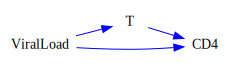

In [ ]:
vertices = ['ViralLoad', 'T', 'CD4']
di_edges = [('ViralLoad', 'T'), ('ViralLoad', 'CD4'), ('T', 'CD4')]
G = ADMG(vertices, di_edges)
G.draw(direction="LR")

In [ ]:
ace_obj = CausalEffect(graph=G, treatment='T', outcome='CD4')  # setting up the CausalEffect object


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



In [ ]:
data = load_conditionally_ignorable_data() # loading the data
ace = ace_obj.compute_effect(data, "eff-aipw") # computing the effect 
print("ace = ", ace, "\n")

ace =  0.9848858526281818 



In [ ]:
data.describe()

,ViralLoad,T,CD4,ones,primal
count,2000.000000,2000.000000,2000.000000,2000.0,2000.000000
mean,0.020604,0.618000,0.661069,1.0,0.073617
std,1.481587,0.485998,2.463352,0.0,4.603568
min,-4.639342,0.000000,-7.024123,1.0,-54.293435
25%,-0.926327,0.000000,-1.008469,1.0,-0.000000
50%,-0.027728,1.000000,0.693808,1.0,0.000000
75%,0.997074,1.000000,2.331722,1.0,0.000000
max,5.412556,1.000000,8.825421,1.0,21.309219


## Example of DAG data generated from CDT

In [ ]:
from cdt.data import AcyclicGraphGenerator
generator = AcyclicGraphGenerator('linear', npoints=1000, nodes=3)
data, graph = generator.generate(rescale=True)
# generator.to_csv('generated_graph')

In [ ]:
from utils import plot_DAG
import networkx as nx
from IPython.display import Image, display

print(nx.is_directed_acyclic_graph(graph))
print(graph.in_degree)
print(graph.out_degree)
print(graph.edges)
print("Edges", nx.number_of_edges(graph))
print("Nodes", nx.number_of_nodes(graph))

display(nx.draw_shell(graph))

True
[('V0', 0), ('V1', 1), ('V2', 2)]
[('V0', 2), ('V1', 1), ('V2', 0)]
[('V0', 'V1'), ('V0', 'V2'), ('V1', 'V2')]
Edges 3
Nodes 3


None

In [ ]:
# import pandas_profiling as pp

# pp.ProfileReport(data) #to display the report

### Check Varsortability of generated Data 

from (https://github.com/Scriddie/Varsortability) but corrected because it errors

In [ ]:
import numpy as np


def varsortability(X, W, debug=False):
    """ Takes n x d data and a d x d adjaceny matrix,
    where the i,j-th entry corresponds to the edge weight for i->j,
    and returns a value indicating how well the variance order
    reflects the causal order. """
    E = W != 0
    Ek = E.copy()
    var = np.var(X, axis=0, keepdims=True)
    tol = var.min() * 1e-9

    n_paths = 0
    n_correctly_ordered_paths = 0

#     for k in range(E.shape[0] - 1):
    n_paths += Ek.sum()
    if debug:
        print("Ek.sum",Ek.sum())
        print("n_paths",n_paths)
        print("var",var, var.T, (var / var.T))
        print("n_corrrect", n_correctly_ordered_paths)
    n_correctly_ordered_paths += np.multiply(Ek,var / var.T > 1 + tol).sum()
    print("n_corrrect", n_correctly_ordered_paths,"/",n_paths)
    if debug:
        print("n_correct: varsort", (var / var.T > 1 + tol), "n_var_paths", (var / var.T > 1 + tol).sum(),
              "masking", np.multiply(Ek,var / var.T > 1 + tol),
              "all", n_correctly_ordered_paths, "tol",1 + tol)
        print("Ek",Ek)
        print("E", E)
        Ek = Ek.dot(E)
        print("Ekd", Ek)

    return n_correctly_ordered_paths / n_paths

In [ ]:
varsortability(data.to_numpy(), nx.to_numpy_matrix(graph), debug=False)

n_corrrect 0 / 3


0.0

## Example from CASTLE

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import math
import networkx as nx
import random
import pandas as pd
#import tensorflow as tf
#Disable TensorFlow 2 behaviour
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler  
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os
from sklearn.metrics import mean_squared_error
from CASTLE2 import CASTLE
from utils import gen_random_dag, gen_data_nonlinear, heat_mat, plot_DAG, DAG_retreive_np, save_pickle, load_pickle, random_stability
from signal import signal, SIGINT
from sys import exit
import argparse
import plotly.express as px
import itertools


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
## Parameters Definition
random_dag = False
csv = 'synth_nonlinear.csv'
num_nodes = 10
branchf = 2
dataset_sz = 1000
output_log = 'castle.log'
n_folds = 1
reg_lambda = 1
reg_beta = 5
gpu = ''
ckpt_file = 'tmp.ckpt'
extension = ''
seed = 2020


force_refit = True ## Refits the model if already present, False will only load it from ckpt_file
tuned = False ## Loads a tuned model saved in ckpt_file + "tuned"

tune = False ## Injects a loaded_adj into a model loaded from ckpt_file 
loaded_adj = None ## Adjacency matrix to be injected


In [ ]:
if random_dag:
    def swap_cols(df, a, b):
        df = df.rename(columns = {a : 'temp'})
        df = df.rename(columns = {b : a})
        return df.rename(columns = {'temp' : b})
    def swap_nodes(G, a, b):
        newG = nx.relabel_nodes(G, {a : 'temp'})
        newG = nx.relabel_nodes(newG, {b : a})
        return nx.relabel_nodes(newG, {'temp' : b})
    
    #Random DAG
    num_edges = int(num_nodes*branchf)
    G = gen_random_dag(num_nodes, num_edges, seed)

    noise = random.uniform(0.3, 1.0)
    print("Setting noise to ", noise)
    
    df = gen_data_nonlinear(G, SIZE = dataset_sz, var = noise).iloc[:dataset_sz]
    df_test =  gen_data_nonlinear(G, SIZE = int(dataset_sz*0.25), var = noise)
    
    for i in range(len(G.edges())):
        if len(list(G.predecessors(i))) > 0:
            df = swap_cols(df, str(0), str(i))
            df_test = swap_cols(df_test, str(0), str(i))
            G = swap_nodes(G, 0, i)
            break     
            
    df = pd.DataFrame(df)
    df_test = pd.DataFrame(df_test)  
    
    #print("Number of parents of G", len(list(G.predecessors(i))))
    print("Edges = ", len(G.edges()), list(G.edges()))
    
else:
    '''
    Toy DAG
    The node '0' is the target in the Toy DAG
    '''
    G = nx.DiGraph()
    for i in range(10):
        G.add_node(i)
    G.add_edge(1,2)
    G.add_edge(1,3)
    G.add_edge(1,4)
    G.add_edge(2,5)
    G.add_edge(2,0)
    G.add_edge(3,0)
    G.add_edge(3,6)
    G.add_edge(3,7)
    G.add_edge(6,9)
    G.add_edge(0,8)
    G.add_edge(0,9)

scaler = StandardScaler()
if csv:
    df = pd.read_csv(csv)      
    df_test = df.iloc[-1000:]
    df = df.iloc[:dataset_sz]
else: 
    df = gen_data_nonlinear(G, SIZE = dataset_sz)
    df_test = gen_data_nonlinear(G, SIZE = 1000)
        
# scaler = StandardScaler()
if random_dag:
    df = scaler.fit_transform(df)
else:
    if csv:
        scaler.fit(pd.read_csv(csv))
        df = scaler.transform(df)
    else:
        df = scaler.fit_transform(df)

df_test = scaler.transform(df_test)

X_test = df_test
y_test = df_test[:,0]
X_DAG = df

# plot_DAG(mat=G, graphic_type='py', debug=False, ori_dag=None, names=None)

varsortability(df,nx.to_numpy_matrix(G), debug=True)


Total Number of Edges in G: 11
Max in degree: 2
DAG: True


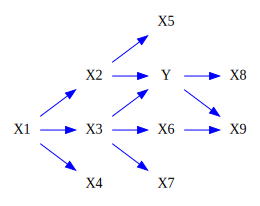

In [ ]:
vertices = ["Y"] + ['X{}'.format(str(i)) for i in range(1,10)]
di_edges = [('X1', 'X2'), ('X1', 'X3'), ('X1', 'X4'), ('X2', 'X5'), ('X2', 'Y'), ('X3', 'Y'), ('X3', 'X6'), ('X3', 'X7'), ('X6', 'X9'), ('Y', 'X8'), ('Y', 'X9')]
# bi_edges = [('X1','Y')]
G = ADMG(vertices, di_edges
# , bi_edges
)
G.draw(direction="LR")

In [ ]:
ace_obj = CausalEffect(graph=G, treatment='X1', outcome='Y')  # setting up the CausalEffect object


 Treatment is a-fixable and graph is mb-shielded. 

 Available estimators are:
 
1. IPW (ipw)
2. Outcome regression (gformula)
3. Generalized AIPW (aipw)
4. Efficient Generalized AIPW (eff-aipw) 
 
Suggested estimator is Efficient Generalized AIPW 



In [ ]:
data = pd.read_csv(csv) 
data.columns = vertices
# ace = ace_obj.compute_effect(data, "eff-apipw") # computing the effect 
# print("ace = ", ace, "\n")

## Create binary data

[0.06676195 0.00654682 0.56789147 ... 0.25817664 0.04054594 0.01905427]
                 Z            X            Y
count  5000.000000  5000.000000  5000.000000
mean      0.229400     0.533400     0.393200
std       0.420489     0.498933     0.488509
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     1.000000     0.000000
75%       0.000000     1.000000     1.000000
max       1.000000     1.000000     1.000000
                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.247
Model:                            OLS   Adj. R-squared (uncentered):              0.247
Method:                 Least Squares   F-statistic:                              821.1
Date:                Fri, 31 Dec 2021   Prob (F-statistic):                   4.76e-309
Time:                        10:40:23   Log-Likelihood:                         -40

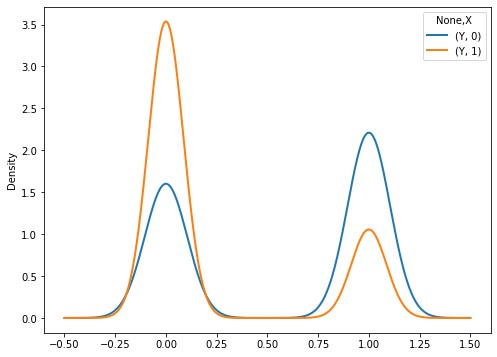

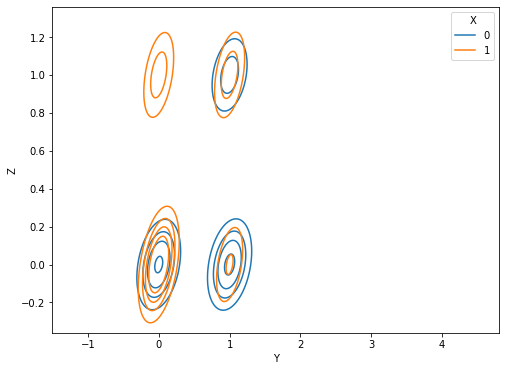

In [44]:
random_stability(123)
N = 5000

xy_coef = 2.
zy_coef = -2.

zx_coef = -0.5
uy_coef = 0.1

# z_transform = lambda x : np.log(x)

# z = np.random.uniform(size=N)
u = np.random.normal(size=N, loc=0., scale=1.)

uz = np.random.normal(size=N, loc=2., scale=2.)

z = np.random.binomial(1., p=1./(1. + np.exp(uz)))
print(1./(1. + np.exp(uz)))
x = np.random.binomial(1., p=1./(1. + np.exp(zx_coef * z)))

y = np.random.binomial(1., p=1./(1. + np.exp(zy_coef * z + xy_coef * x + uy_coef* u)))

# y2 =  (y > y.mean()).astype(float)

# y2
#z_transform(
    # ) 
    

data = pd.DataFrame({'Z': z, 'X': x, 'Y': y})

print(data.describe())

import statsmodels.api as sm
mod = sm.OLS(data[['Y']], data[['X','Z']])
fii = mod.fit()
print(fii.summary())

print('Total Effect:',data[data['X']==1.].mean(axis=0)['Y'],'-',data[data['X']==0.].mean(axis=0)['Y'], '=', (data[data['X']==1.].mean(axis=0) - data[data['X']==0.].mean(axis=0))['Y'])

data_wide = data.pivot(columns = 'X', values = ['Y'])
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 2)

plt.show()

# features = data[['X','Y','Z']].values.T
# plt.scatter(features[1], features[2], alpha=0.2,
#             # s=100*features[0], 
#             c=data.X, cmap='coolwarm'
#             )
# plt.xlabel(data[['X','Y','Z']].columns[1])
# plt.ylabel(data[['X','Y','Z']].columns[2]);
# plt.show()

fig, ax = plt.subplots(figsize= (8, 6))
ax.set(xlim=(-1.5, 4.8))
sns.kdeplot(ax=ax, data=data[['X','Y','Z']], x="Y", y="Z", hue="X",
            levels=5, thresh=.1, fill=False,
            )

plt.show()

